In [53]:
import Ouzo_Graph_Tools as ouzo_graphs
import Ouzo_Sampling_Wtf_Lattice_Volume as create
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import numpy as np
from scipy import interpolate, stats

In [54]:
def extract_plates(path, sheet_list):
    """Will return a sublist of plates absorbance information in dataframe format
    Must ensure that excel sheet has only the samples made in the csv plan as will cause errors downstream."""
    plate_dfs = []
    for sheet_name in sheet_list:
        plate_df = pd.read_excel(path, sheet_name = sheet_name).T
        plate_dfs.append(plate_df)
    return plate_dfs

In [55]:
def merge_wavelength_dfs(df_list):
    merge_list = []
    for i, df in enumerate(df_list):
        if i == 0:
            df = df
        else: 
            df = df.drop(['Wavelength'])
        merge_list.append(df)
    return pd.concat(merge_list)

In [56]:
def baseline_correction(df_samples, baseline_series): 
    """Given the series iloc of a the blank, subtracts the value at every wavelength of blank at resp. wavelength. 
    Simple subtraction blanking."""
    new_df_con = []
    for key, row in df_samples.iterrows():
        if key == 'Wavelength':
            wavelengths = row
            new_df_con.append(wavelengths)
        else: 
            series = row
            corrected = series.subtract(baseline_series)
            new_df_con.append(corrected)
    
    baseline_corrected_df = pd.concat(new_df_con, axis = 1).T
    baseline_corrected_df.index = df_samples[0].index
    return baseline_corrected_df

In [5]:
def add_abs_to_sample_info(sample_info_df, abs_df):
    
    wavelengths = list(abs_df.loc['Wavelength'])
    wavelengths_names = [str(wavelength)+'nm' for wavelength in wavelengths]
    abs_df.columns = wavelengths_names
    
    
    sample_info_df.reset_index(drop=True, inplace=True)
    abs_df.reset_index(drop=True, inplace=True)
    combined_df = pd.concat([sample_info, abs_df], axis = 1)
    return combined_df

In [6]:
def remove_visual_outliers(x, y, z, z_score_threshold = 3):
    """This is not a to remove statistical outliers, only to remove values which present. Outliers will be 
    removed based on the data of z and subsequently from x and y given the same indexes of entries. Inputs must be nparrays"""

    z_array = np.asarray(z)
    z_scores = np.abs(stats.zscore(np.asarray(z)))
    threshold = z_score_threshold
    index_to_remove = np.where(z_scores > threshold)[0] # must be in ascending order
    
    x = x.copy()
    y = y.copy()
    z = z.copy()
    
    for index in reversed(index_to_remove): # reveresed to perserve index
        del x[index]
        del y[index]
        del z[index]
    
    xyz_array = [x,y,z]
    return xyz_array


In [7]:
# what happens with overflow or undefined data???

In [48]:
# Load all things needed in this case
sample_info = pd.read_csv(r"C:\Users\Edwin\Desktop\11_11_20\experiment_info") # make it find the blank position from sample_info
plate_names = ['Sheet1','Sheet2']
plate_dfs = extract_plates(r"C:\Users\Edwin\Desktop\11_11_20\11_11_2020_Plate1.xlsx", plate_names) # can edit/remove wells accidently measured etc, but really should be done at excel level
merged_df = merge_wavelength_dfs(plate_dfs)
plate_dfs

[                 0        1        2        3        4        5        6   \
 Wavelength  400.000  405.000  410.000  415.000  420.000  425.000  430.000   
 A1            0.098    0.095    0.092    0.090    0.088    0.086    0.084   
 A2            0.791    0.782    0.774    0.771    0.767    0.769    0.769   
 A3            0.083    0.081    0.079    0.078    0.076    0.075    0.073   
 A4            0.098    0.095    0.093    0.090    0.088    0.087    0.085   
 A5            0.098    0.095    0.093    0.091    0.089    0.087    0.085   
 A6            0.105    0.102    0.099    0.097    0.095    0.093    0.091   
 A7            0.091    0.088    0.086    0.084    0.082    0.080    0.078   
 A8            0.098    0.094    0.092    0.089    0.087    0.085    0.084   
 B1            0.094    0.091    0.088    0.086    0.085    0.083    0.081   
 B2            0.091    0.088    0.086    0.084    0.082    0.081    0.079   
 B3            0.089    0.086    0.084    0.082    0.081    0.08

In [9]:
# baseline and combine
baseline_series = merged_df.iloc[-1]
merged_baselined_df = baseline_correction(merged_df, baseline_series)
combined_df = add_abs_to_sample_info(sample_info, merged_baselined_df)

In [28]:
# extract data by dict method of df calling series
wavelength = '400.0nm'
x_name = combined_df['Component 4 wtf'][0]
y_name = combined_df['Component 3 wtf'][0]
x = [float(i) for i in combined_df['Component 4 wtf'][1:].tolist()][:-1]
y = [float(i) for i in combined_df['Component 3 wtf'][1:].tolist()][:-1] # removes name of component from list
z = [float(i) for i in combined_df[wavelength][1:].tolist()][:-1]
combined_restricted_xyz = [x,y,z]
modi = remove_visual_outliers(x,y,z,2) # this should only be used to find the new vmin and vmax but not to exclude

In [29]:
print(len(modi[2]))

94


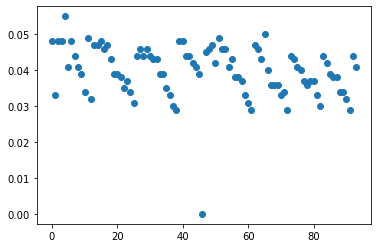

In [30]:
plt.scatter(range(len(modi[2])), modi[2])

In [31]:
min_x = min(combined_restricted_xyz[0])
max_x = max(combined_restricted_xyz[0])
min_y = min(combined_restricted_xyz[1])
max_y = max(combined_restricted_xyz[1])
min_z = min(modi[2])
max_z = max(modi[2])
# print(max_z)

Text(0, 0.5, 'PFH wtf')

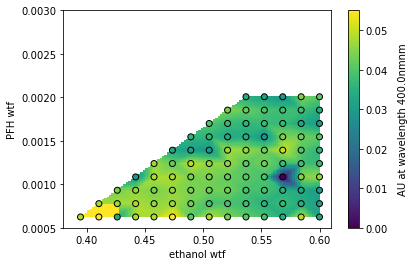

In [52]:

### First make the xx,yy coordinates that the interpolation will span
x_space = np.linspace(min_x,max_x,100)  
y_space = np.linspace(min_y,max_y,100)
xx, yy = np.meshgrid(x_space,y_space) 

### Next make tuple the x,y data so it can be fed into interpolation method to make the interpolation mesh

cartcoord = list(zip(combined_restricted_xyz[0],combined_restricted_xyz[1]))
interp = interpolate.LinearNDInterpolator(cartcoord, combined_restricted_xyz[2])
Z0 = interp(xx,yy)


cartcoord_v = list(zip(modi[0],modi[1]))
interp_v= interpolate.LinearNDInterpolator(cartcoord_v, modi[2])
Z0_v = interp(xx,yy) # does not work as still interpolates far out and makes a v_max that is the same as z0??


# Finally, create the plot. 
# Note: Mappable for the interpolation is independent of the scatter colormap (which is created automatically), they are the same when you do not restrict either.
# Restriction is defined once you restrict the x/y space of the mesh to a space smaller than that of the scatter plot. 

fig, ax = plt.subplots()
vmin = np.nanmin(Z0_v) # so this is will ensure all the interpolations will fit on the colorbar
vmax = np.nanmax(Z0_v)

# norm=colors.Normalize(vmin=min_z, vmax=max_z) # but you can manually use your dat which is the most import to plot to find the range excl outliers
norm=colors.Normalize(vmin=min_z, vmax=max_z)

mappable = ax.pcolormesh(xx, yy, Z0, norm=norm)
# mappable.set_clim(vmin=vmin, vmax=vmax)
# mappable.set_clim(vmin,vmax)


ax.scatter(combined_restricted_xyz[0], combined_restricted_xyz[1], 
           c = combined_restricted_xyz[2], norm=norm, cmap = mpl.cm.viridis, edgecolors='k')

cbar = plt.colorbar(mappable)

cbar_txt = "AU at wavelength " + str(wavelength) + 'nm'
cbar.set_label(cbar_txt, labelpad = 10)
# ax.set_xlim(xmin =0, xmax = 0.0006) # simple ratios for easy viewing
ax.set_ylim([0.0005, 0.003])
ax.set_xlim([0.38,0.610])
# ax.set_yticks(np.arange(-0.0001, 0.00035, 0.0001))
# ax.set_yticks(np.arange(0, 0.0007, 0.00005))
# ax.set_xticks(np.arange(0, 0.00035, 0.001))
# axacx.yticks(np.arange(min, max, step))
ax.set_xlabel(x_name)
ax.set_ylabel(y_name)
# ax.set_xlim([-0.0001,0.0006])
# ax.text(0.4,0.002, "vmin = " + str(vmin) + '\nvmax = '+ str(vmax))

# ax.text(0.4,0.002,'*Negative AU values due to \n instrument resolution of 0.001 AU')
# ax.set_ylim([0,0.05])

In [197]:
remove_index[0]

NameError: name 'remove_index' is not defined

In [ ]:
zmin = min(z)
zmax = max(z)

# so knowing this informaiton or even using the interpolation infomation you could look at the frequncy of certain values and if low enough could be deteremiend to push out in the the color bar extreme to imprve visuals
# so if you have 100 samples between 0.1 and 0.2 and 4 samples between 0.6 and 0.65 it would be fine to have vmin/vmax = 0.1 to 0.2

In [ ]:
# so can use clim, but the big issue is that vmin and vmax are nan

In [ ]:
import seaborn as sns
sns.boxplot(x=z)